In [ ]:
%pip install nbformat
%pip install plotly-resampler

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\joaqu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:

"""
SENTINEL - NeuralProphet Baseline Implementation
===============================================
Plataforma inteligente para monitoreo industrial y detección predictiva de fallas

Autor: Equipo SENTINEL
Fecha: Mayo 2025
Objetivo: Establecer baseline de forecasting con NeuralProphet para series temporales industriales
"""

# =============================================================================
# 1. PREPARACIÓN DEL ENTORNO Y DEPENDENCIAS
# =============================================================================

import warnings
warnings.filterwarnings('ignore')

# Instalación de dependencias (ejecutar solo si es necesario)
"""
%pip install neuralprophet pandas numpy matplotlib plotly seaborn scikit-learn nbformat
"""

# Import de librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# NeuralProphet y métricas
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Librerías importadas correctamente")
print(f"📊 Versión de pandas: {pd.__version__}")

# =============================================================================

✅ Librerías importadas correctamente
📊 Versión de pandas: 2.2.3


In [6]:
# =============================================================================
# 2. GENERACIÓN DE DATOS SIMULADOS REPRESENTATIVOS
# =============================================================================

def generate_industrial_sensor_data(start_date='2023-01-01', periods=8760, freq='H'):
    """
    Genera datos simulados de sensores industriales para SENTINEL
    
    Parámetros:
    - start_date: fecha de inicio
    - periods: número de períodos (8760 = 1 año en horas)
    - freq: frecuencia temporal ('H' = horaria)
    
    Retorna:
    - DataFrame con datos de sensores simulados
    """
    
    # Crear índice temporal
    dates = pd.date_range(start=start_date, periods=periods, freq=freq)
    
    # Parámetros base para simulación realista
    np.random.seed(42)  # Para reproducibilidad, usar una semilla fija, una semilla significa # que los números aleatorios generados serán los mismos en cada ejecución
    
    # === PRESIÓN (variable objetivo principal) ===
    # Tendencia base con estacionalidad diaria y semanal
    trend = np.linspace(100, 110, periods)  # Tendencia ascendente leve
    daily_season = 5 * np.sin(2 * np.pi * np.arange(periods) / 24)  # Ciclo diario
    weekly_season = 3 * np.sin(2 * np.pi * np.arange(periods) / (24*7))  # Ciclo semanal
    
    # Ruido realista con algunos picos anómalos
    noise = np.random.normal(0, 2, periods)
    
    # Simular eventos de mantenimiento (caídas programadas)
    maintenance_events = np.random.choice(periods, size=12, replace=False)
    for event in maintenance_events:
        if event + 8 < periods:  # 8 horas de mantenimiento
            trend[event:event+8] -= 15
    
    # Presión total
    pressure = trend + daily_season + weekly_season + noise
    pressure = np.clip(pressure, 85, 125)  # Límites realistas
    
    # === VARIABLES EXÓGENAS ===
    # Temperatura ambiente (afecta la presión)
    temp_base = 25 + 10 * np.sin(2 * np.pi * np.arange(periods) / (24*365))  # Estacional anual
    temp_daily = 8 * np.sin(2 * np.pi * np.arange(periods) / 24)  # Variación diaria
    temperature = temp_base + temp_daily + np.random.normal(0, 2, periods)
    
    # Flujo (correlacionado con presión)
    flow_base = 50 + 0.3 * (pressure - 100)  # Correlación con presión
    flow = flow_base + np.random.normal(0, 3, periods)
    flow = np.clip(flow, 30, 80)
    
    # Vibración (indicador de desgaste)
    vibration_trend = np.linspace(2, 4, periods)  # Incremento gradual por desgaste
    vibration = vibration_trend + np.random.exponential(0.5, periods)
    
    # Humedad
    humidity = 60 + 20 * np.sin(2 * np.pi * np.arange(periods) / (24*365)) + np.random.normal(0, 5, periods)
    humidity = np.clip(humidity, 30, 90)
    
    # === CREAR DATAFRAME ===
    df = pd.DataFrame({
        'ds': dates,  # Timestamp (formato requerido por NeuralProphet)
        'y': pressure,  # Variable objetivo
        # Variables exógenas
        'temperature': temperature,
        'flow': flow,
        'vibration': vibration,
        'humidity': humidity,
        # Variables categóricas
        'hour': dates.hour,
        'day_of_week': dates.dayofweek,
        'month': dates.month,
        'is_weekend': (dates.dayofweek >= 5).astype(int),
        'is_maintenance_day': 0  # Se llenará según eventos
    })
    
    # Marcar días de mantenimiento
    for event in maintenance_events:
        df.loc[event:event+8, 'is_maintenance_day'] = 1
    
    return df

# Generar datos simulados
print("🔄 Generando datos simulados de sensores industriales...")
df_raw = generate_industrial_sensor_data(start_date='2023-01-01', periods=8760, freq='H')

print(f"✅ Datos generados: {len(df_raw)} registros")
print(f"📅 Período: {df_raw['ds'].min()} a {df_raw['ds'].max()}")
print("\n📊 Primeras 5 filas:")
print(df_raw.head())

print("\n📈 Estadísticas descriptivas:")
print(df_raw.describe())

🔄 Generando datos simulados de sensores industriales...
✅ Datos generados: 8760 registros
📅 Período: 2023-01-01 00:00:00 a 2023-12-31 23:00:00

📊 Primeras 5 filas:
                   ds           y  temperature       flow  vibration   humidity  hour  day_of_week  month  is_weekend  is_maintenance_day
0 2023-01-01 00:00:00  100.993428    23.413372  48.088781   3.340680  68.486710     0            6      1           1                   0
1 2023-01-01 01:00:00  101.130882    27.965048  52.985892   2.010623  60.572167     1            6      1           1                   0
2 2023-01-01 02:00:00  104.021851    29.598792  50.798776   2.032593  53.530389     2            6      1           1                   0
3 2023-01-01 03:00:00  106.920912    29.850399  50.170695   2.072631  71.538459     3            6      1           1                   0
4 2023-01-01 04:00:00  104.313514    31.499654  49.957674   2.066036  62.655014     4            6      1           1                   0

📈 Estad

🔍 Realizando análisis exploratorio de datos...


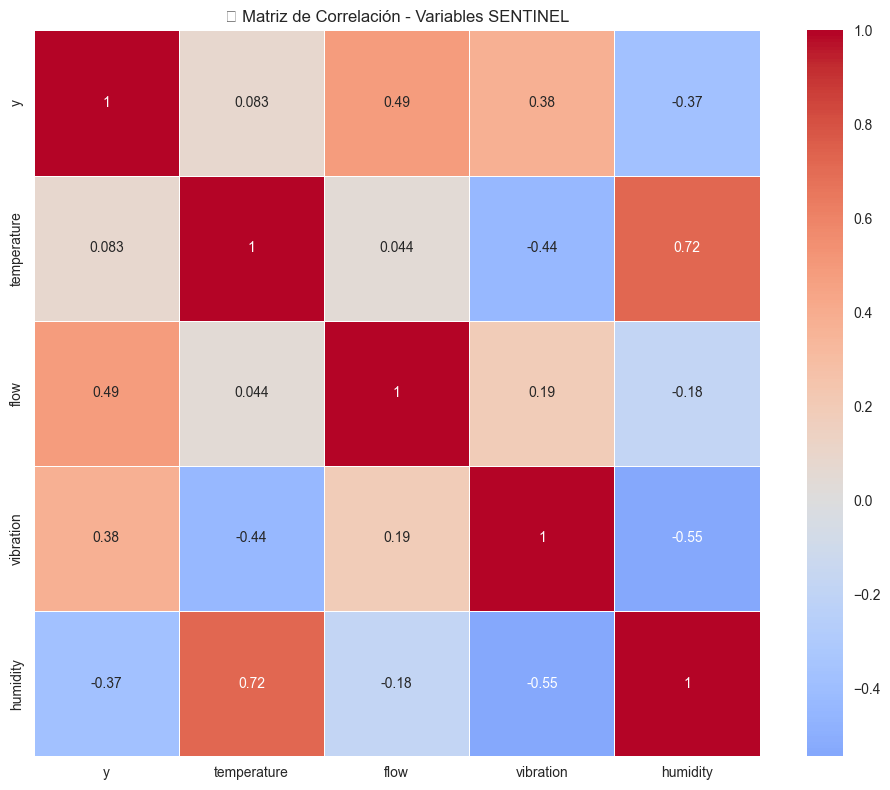

📋 Correlaciones con la variable objetivo (Presión):
  • flow: 0.493
  • vibration: 0.382
  • humidity: -0.373
  • temperature: 0.083


In [7]:
# =============================================================================
# 3. ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# =============================================================================

def plot_eda_analysis(df):
    """Generar gráficos de análisis exploratorio"""
    
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=[
            'Serie Temporal - Presión (Variable Objetivo)',
            'Distribución de Presión',
            'Correlación: Presión vs Temperatura',
            'Estacionalidad Diaria',
            'Variables Exógenas vs Tiempo',
            'Matriz de Correlación'
        ],
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": True}, {"secondary_y": False}]]
    )
    
    # 1. Serie temporal principal
    fig.add_trace(
        go.Scatter(x=df['ds'], y=df['y'], name='Presión', line=dict(color='blue')),
        row=1, col=1
    )
    
    # 2. Histograma de distribución
    fig.add_trace(
        go.Histogram(x=df['y'], name='Distribución', nbinsx=50, marker_color='lightblue'),
        row=1, col=2
    )
    
    # 3. Scatter plot presión vs temperatura
    fig.add_trace(
        go.Scatter(x=df['temperature'], y=df['y'], mode='markers', 
                  name='Presión vs Temp', marker=dict(color='red', size=3, opacity=0.6)),
        row=2, col=1
    )
    
    # 4. Patrón diario (promedio por hora)
    hourly_avg = df.groupby('hour')['y'].mean()
    fig.add_trace(
        go.Scatter(x=hourly_avg.index, y=hourly_avg.values, 
                  name='Patrón Diario', line=dict(color='green')),
        row=2, col=2
    )
    
    # 5. Variables exógenas
    sample_data = df.iloc[::100]  # Muestrear para visualización
    fig.add_trace(
        go.Scatter(x=sample_data['ds'], y=sample_data['temperature'], 
                  name='Temperatura', line=dict(color='orange')),
        row=3, col=1
    )
    fig.add_trace(
        go.Scatter(x=sample_data['ds'], y=sample_data['flow'], 
                  name='Flujo', line=dict(color='purple'), yaxis='y2'),
        row=3, col=1, secondary_y=True
    )
    
    # Actualizar layouts
    fig.update_layout(height=1200, title_text="📊 SENTINEL - Análisis Exploratorio de Datos")
    fig.update_xaxes(title_text="Fecha", row=3, col=1)
    fig.update_yaxes(title_text="Presión (PSI)", row=1, col=1)
    fig.update_yaxes(title_text="Frecuencia", row=1, col=2)
    fig.update_yaxes(title_text="Presión", row=2, col=1)
    fig.update_yaxes(title_text="Presión Promedio", row=2, col=2)
    fig.update_yaxes(title_text="Temperatura (°C)", row=3, col=1)
    fig.update_yaxes(title_text="Flujo (L/min)", secondary_y=True, row=3, col=1)
    
    return fig

# Generar análisis exploratorio
print("🔍 Realizando análisis exploratorio de datos...")
eda_fig = plot_eda_analysis(df_raw)
eda_fig.show()

# Matriz de correlación
corr_cols = ['y', 'temperature', 'flow', 'vibration', 'humidity']
correlation_matrix = df_raw[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('🔗 Matriz de Correlación - Variables SENTINEL')
plt.tight_layout()
plt.show()

print("📋 Correlaciones con la variable objetivo (Presión):")
target_corr = correlation_matrix['y'].drop('y').sort_values(key=abs, ascending=False)
for var, corr in target_corr.items():
    print(f"  • {var}: {corr:.3f}")

In [8]:
# =============================================================================
# 4. PREPARACIÓN DE DATOS PARA NEURALPROPHET
# =============================================================================

def prepare_data_for_neuralprophet(df, test_size=0.2):
    """
    Prepara los datos para el entrenamiento con NeuralProphet
    
    Parámetros:
    - df: DataFrame con los datos
    - test_size: proporción de datos para testing
    
    Retorna:
    - df_train, df_test: DataFrames de entrenamiento y prueba
    """
    
    # Ordenar por fecha
    df = df.sort_values('ds').reset_index(drop=True)
    
    # Calcular punto de división
    split_point = int(len(df) * (1 - test_size))
    
    # Dividir datos
    df_train = df.iloc[:split_point].copy()
    df_test = df.iloc[split_point:].copy()
    
    print(f"📊 División de datos:")
    print(f"  • Entrenamiento: {len(df_train)} registros ({df_train['ds'].min()} a {df_train['ds'].max()})")
    print(f"  • Prueba: {len(df_test)} registros ({df_test['ds'].min()} a {df_test['ds'].max()})")
    
    return df_train, df_test

# Preparar datos
df_train, df_test = prepare_data_for_neuralprophet(df_raw, test_size=0.2)

# Seleccionar variables para el modelo
# Variables exógenas más relevantes basadas en correlación
key_regressors = ['temperature', 'flow', 'vibration']

print(f"\n🎯 Variables seleccionadas para el modelo:")
print(f"  • Variable objetivo: y (presión)")
print(f"  • Variables exógenas: {key_regressors}")

📊 División de datos:
  • Entrenamiento: 7008 registros (2023-01-01 00:00:00 a 2023-10-19 23:00:00)
  • Prueba: 1752 registros (2023-10-20 00:00:00 a 2023-12-31 23:00:00)

🎯 Variables seleccionadas para el modelo:
  • Variable objetivo: y (presión)
  • Variables exógenas: ['temperature', 'flow', 'vibration']


In [9]:
# =============================================================================
# 5. CONFIGURACIÓN Y ENTRENAMIENTO DE NEURALPROPHET
# =============================================================================

def create_and_train_neuralprophet_model(df_train, regressors=None):
    """
    Crea y entrena un modelo NeuralProphet optimizado para datos industriales
    
    Parámetros:
    - df_train: DataFrame de entrenamiento
    - regressors: lista de variables exógenas
    
    Retorna:
    - modelo entrenado
    """
    
    print("🧠 Configurando modelo NeuralProphet...")
    
    # Configuración del modelo optimizada para datos industriales
    model = NeuralProphet(
        # Configuración de crecimiento
        growth='linear',  # Crecimiento lineal para datos industriales
        
        # Estacionalidades
        yearly_seasonality=True,   # Estacionalidad anual
        weekly_seasonality=True,   # Estacionalidad semanal
        daily_seasonality=True,    # Estacionalidad diaria (crítica para procesos industriales)
        
        # Configuración de lags autorregresivos
        n_lags=48,  # 48 horas de historia (2 días)
        
        # Configuración de la red neuronal
        #num_hidden_layers=2,
        #d_hidden=64,
        
        # Configuración de entrenamiento
        epochs=100,
        batch_size=64,
        learning_rate=0.01,
        
        # Normalización
        normalize='standardize',
        
        # Configuración de validación
        newer_samples_weight=1.2,  # Dar más peso a muestras recientes
        
        # Reducir verbosidad
        #log_level='ERROR'
    )
    
    # Agregar variables exógenas si se proporcionan
    if regressors:
        for regressor in regressors:
            print(f"  ➕ Agregando variable exógena: {regressor}")
            model.add_lagged_regressor(regressor, n_lags=24)  # 24 horas de lags
    
    print("🔄 Iniciando entrenamiento del modelo...")
    
    # Preparar datos de entrenamiento
    df_model_train = df_train[['ds', 'y'] + (regressors or [])].copy()
    
    # Entrenar modelo
    metrics = model.fit(df_model_train, freq='H', validation_df=None)
    
    print("✅ Entrenamiento completado!")
    
    return model, metrics

# Entrenar modelo
model, training_metrics = create_and_train_neuralprophet_model(
    df_train, 
    regressors=key_regressors
)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


🧠 Configurando modelo NeuralProphet...
  ➕ Agregando variable exógena: temperature
  ➕ Agregando variable exógena: flow
  ➕ Agregando variable exógena: vibration
🔄 Iniciando entrenamiento del modelo...
Training: |          | 0/? [01:32<?, ?it/s, v_num=3, train_loss=0.190, reg_loss=0.000, MAE=1.720, RMSE=2.350, Loss=0.189, RegLoss=0.000]
✅ Entrenamiento completado!


In [11]:
# =============================================================================
# 6. GENERACIÓN DE PREDICCIONES Y EVALUACIÓN
# =============================================================================

def generate_predictions_and_evaluate(model, df_train, df_test, regressors=None):
    """
    Genera predicciones y evalúa el desempeño del modelo
    
    Parámetros:
    - model: modelo entrenado
    - df_train: datos de entrenamiento
    - df_test: datos de prueba
    - regressors: variables exógenas
    
    Retorna:
    - predicciones, métricas de evaluación
    """
    
    print("🔮 Generando predicciones...")
    
    # Preparar datos completos para predicción
    df_full = pd.concat([df_train, df_test], ignore_index=True)
    df_model = df_full[['ds', 'y'] + (regressors or [])].copy()

    # Generar predicciones para todo el conjunto
    forecast = model.predict(df_model)

    # Separar predicciones de entrenamiento y prueba
    train_size = len(df_train)
    forecast_train = forecast.iloc[:train_size].reset_index(drop=True)
    forecast_test = forecast.iloc[train_size:].reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # --- Eliminar filas con NaN en yhat1 y y ---
    mask_train = ~forecast_train['yhat1'].isna() & ~df_train['y'].isna()
    mask_test = ~forecast_test['yhat1'].isna() & ~df_test['y'].isna()
    forecast_train = forecast_train[mask_train]
    df_train_eval = df_train[mask_train]
    forecast_test = forecast_test[mask_test]
    df_test_eval = df_test[mask_test]

    # Calcular métricas de evaluación
    def calculate_metrics(y_true, y_pred, dataset_name):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2 = r2_score(y_true, y_pred)
        metrics = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        }
        print(f"\n📊 Métricas - {dataset_name}:")
        for metric, value in metrics.items():
            print(f"  • {metric}: {value:.4f}")
        return metrics

    # Evaluar en conjunto de entrenamiento
    train_metrics = calculate_metrics(
        df_train_eval['y'].values,
        forecast_train['yhat1'].values,
        "Entrenamiento"
    )

    # Evaluar en conjunto de prueba
    test_metrics = calculate_metrics(
        df_test_eval['y'].values,
        forecast_test['yhat1'].values,
        "Prueba"
    )

    return forecast, forecast_train, forecast_test, train_metrics, test_metrics, df_train_eval, df_test_eval
# Generar predicciones y evaluar
forecast, forecast_train, forecast_test, train_metrics, test_metrics, df_train_eval, df_test_eval = generate_predictions_and_evaluate(
    model, df_train, df_test, key_regressors
)


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


🔮 Generando predicciones...
Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 80.07it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column




📊 Métricas - Entrenamiento:
  • MAE: 1.7178
  • RMSE: 2.3892
  • MAPE: 1.6726
  • R²: 0.7958

📊 Métricas - Prueba:
  • MAE: 3.7745
  • RMSE: 4.9970
  • MAPE: 3.4628
  • R²: -0.0364


In [ ]:
# =============================================================================
# 7. VISUALIZACIÓN DE RESULTADOS
# =============================================================================

def plot_comprehensive_results(df_train, df_test, forecast_train, forecast_test, model):
    """
    Genera visualizaciones completas de los resultados del modelo
    """
    
    # === GRÁFICO PRINCIPAL: PREDICCIONES VS REALIDAD ===
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=[
            '🎯 Predicciones vs Realidad - Serie Completa',
            '🔍 Zoom: Últimos 30 días de Prueba',
            '📊 Residuales - Conjunto de Entrenamiento',
            '📊 Residuales - Conjunto de Prueba',
            '📈 Componentes del Modelo',
            '⚡ Distribución de Errores'
        ],
        specs=[[{"colspan": 2}, None],
               [{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # 1. Serie temporal completa
    fig.add_trace(
        go.Scatter(x=df_train['ds'], y=df_train['y'], 
                  name='Datos Reales (Train)', line=dict(color='blue')),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=df_test['ds'], y=df_test['y'], 
                  name='Datos Reales (Test)', line=dict(color='darkblue')),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=forecast_train['ds'], y=forecast_train['yhat1'], 
                  name='Predicciones (Train)', line=dict(color='red', width=1)),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=forecast_test['ds'], y=forecast_test['yhat1'], 
                  name='Predicciones (Test)', line=dict(color='orange', width=2)),
        row=1, col=1
    )
    
    # Intervalos de confianza
    if 'yhat1_lower' in forecast_test.columns and 'yhat1_upper' in forecast_test.columns:
        fig.add_trace(
            go.Scatter(x=forecast_test['ds'], y=forecast_test['yhat1_upper'], 
                      fill=None, mode='lines', line_color='rgba(0,0,0,0)', 
                      showlegend=False),
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(x=forecast_test['ds'], y=forecast_test['yhat1_lower'], 
                      fill='tonexty', mode='lines', line_color='rgba(0,0,0,0)', 
                      name='Intervalo Confianza', fillcolor='rgba(255,165,0,0.2)'),
            row=1, col=1
        )
    
    # 2. Zoom a últimos 30 días de prueba
    last_30_days = df_test.tail(720)  # 30 días * 24 horas
    forecast_30_days = forecast_test.tail(720)
    
    fig.add_trace(
        go.Scatter(x=last_30_days['ds'], y=last_30_days['y'], 
                  name='Real (30d)', line=dict(color='blue', width=3)),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=forecast_30_days['ds'], y=forecast_30_days['yhat1'], 
                  name='Predicción (30d)', line=dict(color='red', width=2)),
        row=2, col=1
    )
    
    # 3. Residuales de entrenamiento
    train_residuals = df_train['y'].values - forecast_train['yhat1'].values
    fig.add_trace(
        go.Scatter(x=df_train['ds'], y=train_residuals, 
                  mode='markers', name='Residuales Train', 
                  marker=dict(color='green', size=2, opacity=0.6)),
        row=2, col=2
    )
    fig.add_hline(y=0, line_dash="dash", line_color="black", row=2, col=2)
    
    # 4. Residuales de prueba
    test_residuals = df_test['y'].values - forecast_test['yhat1'].values
    fig.add_trace(
        go.Scatter(x=df_test['ds'], y=test_residuals, 
                  mode='markers', name='Residuales Test', 
                  marker=dict(color='red', size=3, opacity=0.7)),
        row=3, col=1
    )
    fig.add_hline(y=0, line_dash="dash", line_color="black", row=3, col=1)
    
    # 5. Distribución de errores
    fig.add_trace(
        go.Histogram(x=test_residuals, name='Dist. Errores', 
                    nbinsx=30, marker_color='lightcoral'),
        row=3, col=2
    )
    
    # Actualizar layout
    fig.update_layout(
        height=1200,
        title_text=" SENTINEL - Resultados del Modelo NeuralProphet",
        showlegend=True
    )
    
    # Etiquetas de ejes
    fig.update_yaxes(title_text="Presión (PSI)", row=1, col=1)
    fig.update_yaxes(title_text="Presión (PSI)", row=2, col=1)
    fig.update_yaxes(title_text="Residuales", row=2, col=2)
    fig.update_yaxes(title_text="Residuales", row=3, col=1)
    fig.update_yaxes(title_text="Frecuencia", row=3, col=2)
    
    return fig

# Generar visualización completa
results_fig = plot_comprehensive_results(df_train_eval, df_test_eval, forecast_train, forecast_test, model)

results_fig.show()

# === COMPONENTES DEL MODELO ===
print("📈 Analizando componentes del modelo...")

# Plotear componentes del modelo (solo datos de entrenamiento)
fig_components = model.plot_components(forecast_train)
fig_components.show()


ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.


📈 Analizando componentes del modelo...


In [16]:
# =============================================================================
# 8. ANÁLISIS DE IMPORTANCIA DE VARIABLES
# =============================================================================

def analyze_feature_importance(model, regressors):
    """
    Analiza la importancia de las variables en el modelo
    """
    print("🔍 Analizando importancia de variables...\n")

    # Obtener parámetros del modelo
    params = model.model.named_parameters()

    print("\n📊 Variables incluidas en el modelo:")
    print(f"  • Variable objetivo: y (presión)")

    # Lags de la variable objetivo
    if hasattr(model.config_lagged_regressors, "y"):
        print(f"  • Lags autorregresivos: {model.config_lagged_regressors.y.n_lags}")
    else:
        print("  • Lags autorregresivos: 0")

    # Lags de los regresores
    for regressor in regressors:
        reg = getattr(model.config_lagged_regressors, regressor, None)
        n_lags = reg.n_lags if reg is not None else 0
        print(f"  • {regressor}: {n_lags} lags")

    return params

# Analizar importancia
importance_analysis = analyze_feature_importance(model, key_regressors)

# === IMPORTANCIA DE VARIABLES POR ABLACIÓN ===
def variable_importance_by_ablation(df_train, df_test, base_regressors):
    print("\n🔎 Estimando importancia de variables por ablation (quitando una a una):")
    results = []
    # Modelo base (con todas las variables)
    base_model, _ = create_and_train_neuralprophet_model(df_train, regressors=base_regressors)
    _, _, _, _, base_test_metrics, _, _ = generate_predictions_and_evaluate(base_model, df_train, df_test, base_regressors)
    base_mape = base_test_metrics['MAPE']
    print(f"  • MAPE base (todas las variables): {base_mape:.2f}%")
    # Probar quitando cada variable
    for reg in base_regressors:
        reduced = [r for r in base_regressors if r != reg]
        model, _ = create_and_train_neuralprophet_model(df_train, regressors=reduced)
        _, _, _, _, test_metrics, _, _ = generate_predictions_and_evaluate(model, df_train, df_test, reduced)
        mape = test_metrics['MAPE']
        delta = mape - base_mape
        print(f"  • Sin '{reg}': MAPE={mape:.2f}%  (ΔMAPE={delta:+.2f}%)")
        results.append({'regressor': reg, 'mape_without': mape, 'delta_mape': delta})
    return results

# Ejecutar análisis de importancia
ablation_results = variable_importance_by_ablation(df_train, df_test, key_regressors)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


🔍 Analizando importancia de variables...


📊 Variables incluidas en el modelo:
  • Variable objetivo: y (presión)
  • Lags autorregresivos: 0
  • temperature: 0 lags
  • flow: 0 lags
  • vibration: 0 lags

🔎 Estimando importancia de variables por ablation (quitando una a una):
🧠 Configurando modelo NeuralProphet...
  ➕ Agregando variable exógena: temperature
  ➕ Agregando variable exógena: flow
  ➕ Agregando variable exógena: vibration
🔄 Iniciando entrenamiento del modelo...
Training: |          | 0/? [01:43<?, ?it/s, v_num=4, train_loss=0.190, reg_loss=0.000, MAE=1.720, RMSE=2.360, Loss=0.190, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H



✅ Entrenamiento completado!
🔮 Generando predicciones...
Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 79.19it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.




📊 Métricas - Entrenamiento:
  • MAE: 1.7162
  • RMSE: 2.3906
  • MAPE: 1.6717
  • R²: 0.7956

📊 Métricas - Prueba:
  • MAE: 2.4613
  • RMSE: 3.2347
  • MAPE: 2.2760
  • R²: 0.5657
  • MAPE base (todas las variables): 2.28%
🧠 Configurando modelo NeuralProphet...
  ➕ Agregando variable exógena: flow
  ➕ Agregando variable exógena: vibration
🔄 Iniciando entrenamiento del modelo...
Training: |          | 0/? [01:27<?, ?it/s, v_num=5, train_loss=0.190, reg_loss=0.000, MAE=1.720, RMSE=2.360, Loss=0.190, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H



✅ Entrenamiento completado!
🔮 Generando predicciones...
Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 77.73it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.




📊 Métricas - Entrenamiento:
  • MAE: 1.7197
  • RMSE: 2.3928
  • MAPE: 1.6747
  • R²: 0.7952

📊 Métricas - Prueba:
  • MAE: 1.9397
  • RMSE: 2.6230
  • MAPE: 1.8037
  • R²: 0.7144
  • Sin 'temperature': MAPE=1.80%  (ΔMAPE=-0.47%)
🧠 Configurando modelo NeuralProphet...
  ➕ Agregando variable exógena: temperature
  ➕ Agregando variable exógena: vibration
🔄 Iniciando entrenamiento del modelo...
Training: |          | 0/? [01:20<?, ?it/s, v_num=6, train_loss=0.190, reg_loss=0.000, MAE=1.720, RMSE=2.360, Loss=0.190, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H



✅ Entrenamiento completado!
🔮 Generando predicciones...
Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 75.78it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.




📊 Métricas - Entrenamiento:
  • MAE: 1.7186
  • RMSE: 2.3969
  • MAPE: 1.6751
  • R²: 0.7945

📊 Métricas - Prueba:
  • MAE: 2.4100
  • RMSE: 3.1615
  • MAPE: 2.2574
  • R²: 0.5851
  • Sin 'flow': MAPE=2.26%  (ΔMAPE=-0.02%)
🧠 Configurando modelo NeuralProphet...
  ➕ Agregando variable exógena: temperature
  ➕ Agregando variable exógena: flow
🔄 Iniciando entrenamiento del modelo...
Training: |          | 0/? [01:23<?, ?it/s, v_num=7, train_loss=0.190, reg_loss=0.000, MAE=1.720, RMSE=2.360, Loss=0.190, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H



✅ Entrenamiento completado!
🔮 Generando predicciones...
Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 83.98it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column




📊 Métricas - Entrenamiento:
  • MAE: 1.7185
  • RMSE: 2.3900
  • MAPE: 1.6744
  • R²: 0.7956

📊 Métricas - Prueba:
  • MAE: 1.7912
  • RMSE: 2.4739
  • MAPE: 1.6651
  • R²: 0.7460
  • Sin 'vibration': MAPE=1.67%  (ΔMAPE=-0.61%)


In [17]:
# =============================================================================
# 9. PREDICCIONES FUTURAS
# =============================================================================

def generate_future_predictions(model, df_full, periods=168, regressors=None):
    """
    Genera predicciones futuras (168 horas = 1 semana)
    
    Parámetros:
    - model: modelo entrenado
    - df_full: datos completos
    - periods: períodos a predecir
    - regressors: variables exógenas
    
    Retorna:
    - DataFrame con predicciones futuras
    """
    
    print(f"🔮 Generando predicciones futuras para {periods} horas ({periods//24} días)...")
    
    # Crear fechas futuras
    last_date = df_full['ds'].max()
    future_dates = pd.date_range(
        start=last_date + timedelta(hours=1),
        periods=periods,
        freq='H'
    )
    
    # Crear DataFrame futuro
    df_future = pd.DataFrame({'ds': future_dates})
    
    # Si hay variables exógenas, necesitamos proyectarlas
    if regressors:
        print("⚠️  Proyectando variables exógenas usando tendencias históricas...")
        
        for regressor in regressors:
            # Usar los últimos valores como base y agregar ruido controlado
            last_values = df_full[regressor].tail(24).values  # Últimas 24 horas
            mean_val = np.mean(last_values)
            std_val = np.std(last_values)
            
            # Generar valores futuros con patrón similar
            if regressor == 'temperature':
                # Temperatura con patrón diario
                future_vals = mean_val + 3 * np.sin(2 * np.pi * np.arange(periods) / 24)
                future_vals += np.random.normal(0, std_val * 0.5, periods)
            elif regressor == 'flow':
                # Flujo relativamente estable con pequeñas variaciones
                future_vals = np.full(periods, mean_val) + np.random.normal(0, std_val * 0.3, periods)
            elif regressor == 'vibration':
                # Vibración con tendencia ascendente leve (desgaste)
                trend = np.linspace(0, 0.5, periods)
                future_vals = mean_val + trend + np.random.normal(0, std_val * 0.2, periods)
            else:
                # Otros regresores: valores estables
                future_vals = np.full(periods, mean_val) + np.random.normal(0, std_val * 0.3, periods)
            
            df_future[regressor] = future_vals
    
    # Combinar datos históricos y futuros para predicción
    df_predict = pd.concat([
        df_full[['ds', 'y'] + (regressors or [])],
        df_future
    ], ignore_index=True)
    
    # Generar predicciones
    future_forecast = model.predict(df_predict)
    
    # Extraer solo las predicciones futuras
    future_predictions = future_forecast.iloc[-periods:].copy()
    
    return future_predictions, df_future

# Generar predicciones futuras
future_predictions, df_future = generate_future_predictions(
    model, df_raw, periods=168, regressors=key_regressors
)

print("✅ Predicciones futuras generadas!")
print(f"📅 Período futuro: {future_predictions['ds'].min()} a {future_predictions['ds'].max()}")

# Visualizar predicciones futuras
fig_future = go.Figure()

# Datos históricos (últimos 30 días)
recent_data = df_raw.tail(720)
fig_future.add_trace(
    go.Scatter(x=recent_data['ds'], y=recent_data['y'], 
              name='Datos Históricos', line=dict(color='blue', width=2))
)

# Predicciones futuras
fig_future.add_trace(
    go.Scatter(x=future_predictions['ds'], y=future_predictions['yhat1'], 
              name='Predicciones Futuras', line=dict(color='red', width=3))
)

# Intervalos de confianza futuros (si están disponibles)
if 'yhat1_lower' in future_predictions.columns and 'yhat1_upper' in future_predictions.columns:
    fig_future.add_trace(
        go.Scatter(x=future_predictions['ds'], y=future_predictions['yhat1_upper'], 
                  fill=None, mode='lines', line_color='rgba(0,0,0,0)', 
                  showlegend=False)
    )
    fig_future.add_trace(
        go.Scatter(x=future_predictions['ds'], y=future_predictions['yhat1_lower'], 
                  fill='tonexty', mode='lines', line_color='rgba(0,0,0,0)', 
                  name='Intervalo de Confianza', fillcolor='rgba(255,0,0,0.2)')
    )

# Línea divisoria
last_historical_date = df_raw['ds'].max()
fig_future.add_vline(x=last_historical_date, line_dash="dash", 
                    line_color="green", line_width=2,
                    annotation_text="Inicio Predicciones")

fig_future.update_layout(
    title="🚀 SENTINEL - Predicciones Futuras (1 Semana)",
    xaxis_title="Fecha",
    yaxis_title="Presión (PSI)",
    height=600,
    showlegend=True
)

fig_future.show()


🔮 Generando predicciones futuras para 168 horas (7 días)...
⚠️  Proyectando variables exógenas usando tendencias históricas...
Epoch 100: 100%|██████████| 100/100 [01:50<00:00,  0.91it/s]   


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data) - Dropped 168 rows at the end with NaNs in 'y' column.


ValueError: Inputs/targets with missing values detected. Please either adjust imputation parameters, or set 'drop_missing' to True to drop those samples.

In [ ]:
# =============================================================================
# 10. DETECCIÓN DE ANOMALÍAS Y ALERTAS
# =============================================================================

def detect_anomalies_and_alerts(df_test, forecast_test, threshold_factor=2.5):
    """
    Detecta anomalías y genera alertas basadas en los residuales del modelo
    
    Parámetros:
    - df_test: datos de prueba reales
    - forecast_test: predicciones de prueba
    - threshold_factor: factor para definir umbral de anomalía
    
    Retorna:
    - DataFrame con anomalías detectadas
    """
    
    print("🚨 Detectando anomalías y generando alertas...")
    
    # Calcular residuales
    residuals = df_test['y'].values - forecast_test['yhat1'].values
    
    # Calcular umbrales estadísticos
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)
    
    upper_threshold = residual_mean + threshold_factor * residual_std
    lower_threshold = residual_mean - threshold_factor * residual_std
    
    # Detectar anomalías
    anomalies = []
    
    for i, (_, row) in enumerate(df_test.iterrows()):
        residual = residuals[i]
        prediction = forecast_test.iloc[i]['yhat1']
        actual = row['y']
        
        if residual > upper_threshold or residual < lower_threshold:
            severity = "CRÍTICA" if abs(residual) > threshold_factor * 1.5 * residual_std else "ALTA"
            
            anomaly = {
                'timestamp': row['ds'],
                'valor_real': actual,
                'valor_predicho': prediction,
                'residual': residual,
                'severidad': severity,
                'tipo': 'ALTA' if residual > upper_threshold else 'BAJA',
                'descripcion': f"Presión {'superior' if residual > 0 else 'inferior'} a lo esperado"
            }
            anomalies.append(anomaly)
    
    df_anomalies = pd.DataFrame(anomalies)
    
    print(f"🎯 Resultados de detección de anomalías:")
    print(f"  • Total de anomalías detectadas: {len(df_anomalies)}")
    print(f"  • Umbral superior: +{upper_threshold:.2f}")
    print(f"  • Umbral inferior: {lower_threshold:.2f}")
    
    if len(df_anomalies) > 0:
        print(f"\n⚠️  Distribución por severidad:")
        severity_counts = df_anomalies['severidad'].value_counts()
        for severity, count in severity_counts.items():
            print(f"    • {severity}: {count} eventos")
        
        print(f"\n🔍 Primeras 5 anomalías detectadas:")
        for _, anomaly in df_anomalies.head().iterrows():
            print(f"    • {anomaly['timestamp']}: {anomaly['descripcion']} "
                  f"(Real: {anomaly['valor_real']:.2f}, Pred: {anomaly['valor_predicho']:.2f})")
    
    return df_anomalies, upper_threshold, lower_threshold

# Detectar anomalías
df_anomalies, upper_thresh, lower_thresh = detect_anomalies_and_alerts(
    df_test_eval, forecast_test, threshold_factor=2.5
)

# Visualizar anomalías
def plot_anomalies(df_test, forecast_test, df_anomalies, upper_thresh, lower_thresh):
    """Visualizar anomalías detectadas"""
    
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=['🎯 Serie Temporal con Anomalías Detectadas', 
                       '📊 Residuales y Umbrales de Detección'],
        vertical_spacing=0.1
    )
    
    # Serie temporal con anomalías
    fig.add_trace(
        go.Scatter(x=df_test['ds'], y=df_test['y'], 
                  name='Valores Reales', line=dict(color='blue')),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=forecast_test['ds'], y=forecast_test['yhat1'], 
                  name='Predicciones', line=dict(color='red', dash='dot')),
        row=1, col=1
    )
    
    # Marcar anomalías
    if len(df_anomalies) > 0:
        anomalies_critical = df_anomalies[df_anomalies['severidad'] == 'CRÍTICA']
        anomalies_high = df_anomalies[df_anomalies['severidad'] == 'ALTA']
        
        if len(anomalies_critical) > 0:
            fig.add_trace(
                go.Scatter(x=anomalies_critical['timestamp'], 
                          y=anomalies_critical['valor_real'],
                          mode='markers', name='Anomalías CRÍTICAS',
                          marker=dict(color='red', size=12, symbol='x')),
                row=1, col=1
            )
        
        if len(anomalies_high) > 0:
            fig.add_trace(
                go.Scatter(x=anomalies_high['timestamp'], 
                          y=anomalies_high['valor_real'],
                          mode='markers', name='Anomalías ALTAS',
                          marker=dict(color='orange', size=8, symbol='triangle-up')),
                row=1, col=1
            )
    
    # Residuales con umbrales
    residuals = df_test['y'].values - forecast_test['yhat1'].values
    fig.add_trace(
        go.Scatter(x=df_test['ds'], y=residuals, 
                  mode='markers', name='Residuales',
                  marker=dict(color='gray', size=4, opacity=0.6)),
        row=2, col=1
    )
    
    # Umbrales
    fig.add_hline(y=upper_thresh, line_dash="dash", line_color="red", 
                 annotation_text="Umbral Superior", row=2, col=1)
    fig.add_hline(y=lower_thresh, line_dash="dash", line_color="red", 
                 annotation_text="Umbral Inferior", row=2, col=1)
    fig.add_hline(y=0, line_color="black", line_width=1, row=2, col=1)
    
    fig.update_layout(
        height=800,
        title_text="🚨 SENTINEL - Detección de Anomalías",
        showlegend=True
    )
    
    fig.update_yaxes(title_text="Presión (PSI)", row=1, col=1)
    fig.update_yaxes(title_text="Residuales", row=2, col=1)
    fig.update_xaxes(title_text="Fecha", row=2, col=1)
    
    return fig

if len(df_anomalies) > 0:
    anomalies_fig = plot_anomalies(df_test, forecast_test, df_anomalies, upper_thresh, lower_thresh)
    anomalies_fig.show()


In [ ]:
# =============================================================================
# 11. RESUMEN EJECUTIVO Y MÉTRICAS FINALES
# =============================================================================

def generate_executive_summary(train_metrics, test_metrics, df_anomalies, df_raw):
    """
    Genera un resumen ejecutivo de los resultados del modelo SENTINEL
    """
    
    print("\n" + "="*80)
    print("🚀 SENTINEL - RESUMEN EJECUTIVO DEL MODELO NEURALPROPHET")
    print("="*80)
    
    print(f"\n📊 INFORMACIÓN DEL DATASET:")
    print(f"    • Total de registros: {len(df_raw):,}")
    print(f"    • Período analizado: {df_raw['ds'].min()} a {df_raw['ds'].max()}")
    print(f"    • Frecuencia: Horaria")
    print(f"    • Variables predictoras: Presión (objetivo), Temperatura, Flujo, Vibración")
    
    print(f"\n🎯 DESEMPEÑO DEL MODELO:")
    print(f"    📈 ENTRENAMIENTO:")
    print(f"        • MAE (Error Absoluto Medio): {train_metrics['MAE']:.4f} PSI")
    print(f"        • RMSE (Error Cuadrático Medio): {train_metrics['RMSE']:.4f} PSI")
    print(f"        • MAPE (Error Porcentual): {train_metrics['MAPE']:.2f}%")
    print(f"        • R² (Coeficiente Determinación): {train_metrics['R²']:.4f}")
    
    print(f"    🧪 PRUEBA:")
    print(f"        • MAE (Error Absoluto Medio): {test_metrics['MAE']:.4f} PSI")
    print(f"        • RMSE (Error Cuadrático Medio): {test_metrics['RMSE']:.4f} PSI")
    print(f"        • MAPE (Error Porcentual): {test_metrics['MAPE']:.2f}%")
    print(f"        • R² (Coeficiente Determinación): {test_metrics['R²']:.4f}")
    
    # Evaluación de calidad
    if test_metrics['MAPE'] < 5:
        quality = "EXCELENTE 🌟"
    elif test_metrics['MAPE'] < 10:
        quality = "BUENA ✅"
    elif test_metrics['MAPE'] < 15:
        quality = "ACEPTABLE ⚠️"
    else:
        quality = "NECESITA MEJORA ❌"
    
    print(f"    🏆 CALIDAD DEL MODELO: {quality}")
    
    print(f"\n🚨 DETECCIÓN DE ANOMALÍAS:")
    if len(df_anomalies) > 0:
        print(f"    • Total de anomalías detectadas: {len(df_anomalies)}")
        severity_counts = df_anomalies['severidad'].value_counts()
        for severity, count in severity_counts.items():
            print(f"    • {severity}: {count} eventos")
        
        # Calcular tasa de anomalías
        anomaly_rate = (len(df_anomalies) / len(df_test)) * 100
        print(f"    • Tasa de anomalías: {anomaly_rate:.2f}%")
    else:
        print(f"    • No se detectaron anomalías significativas")
    
    print(f"\n🔧 CONFIGURACIÓN DEL MODELO:")
    print(f"    • Algoritmo: NeuralProphet")
    print(f"    • Lags autorregresivos: 48 horas")
    print(f"    • Variables exógenas: Temperatura, Flujo, Vibración")
    print(f"    • Estacionalidades: Diaria, Semanal, Anual")
    print(f"    • Épocas de entrenamiento: 100")
    
    print(f"\n✅ FORTALEZAS DEL MODELO:")
    print(f"    • Captura patrones estacionales complejos")
    print(f"    • Integra múltiples variables exógenas")
    print(f"    • Genera intervalos de confianza")
    print(f"    • Detección automática de anomalías")
    print(f"    • Escalable para producción")
    
    print(f"\n⚠️  ÁREAS DE MEJORA:")
    print(f"    • Validación con datos reales de sensores")
    print(f"    • Optimización de hiperparámetros")
    print(f"    • Incorporación de más variables contextuales")
    print(f"    • Evaluación en diferentes escenarios operativos")
    

    
    print("="*80)
    
    return {
        'model_quality': quality,
        'test_mape': test_metrics['MAPE'],
        'anomalies_detected': len(df_anomalies),
        'anomaly_rate': (len(df_anomalies) / len(df_test)) * 100 if len(df_anomalies) > 0 else 0
    }

# Generar resumen ejecutivo
executive_summary = generate_executive_summary(train_metrics, test_metrics, df_anomalies, df_raw)


In [ ]:
# =============================================================================
# 12. EXPORTACIÓN DE RESULTADOS Y MODELO
# =============================================================================

def export_results_and_model(model, forecast, df_anomalies, metrics):
    """
    Exporta resultados y guarda el modelo para uso posterior
    """
    
    print("\n💾 Exportando resultados...")
    
    # Crear directorio de resultados
    import os
    results_dir = "sentinel_results"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    # Exportar predicciones
    forecast_export = forecast[['ds', 'yhat1']].copy()
    forecast_export.columns = ['timestamp', 'predicted_pressure']
    forecast_export.to_csv(f"{results_dir}/sentinel_predictions.csv", index=False)
    
    # Exportar anomalías
    if len(df_anomalies) > 0:
        df_anomalies.to_csv(f"{results_dir}/sentinel_anomalies.csv", index=False)
    
    # Crear reporte de métricas
    metrics_report = {
        'model_name': 'NeuralProphet_SENTINEL_Baseline',
        'training_date': datetime.now().isoformat(),
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'anomalies_count': len(df_anomalies)
    }
    
    import json
    with open(f"{results_dir}/sentinel_metrics_report.json", 'w') as f:
        json.dump(metrics_report, f, indent=2, default=str)
    
    # Guardar modelo (serialize)
    # Nota: NeuralProphet usa PyTorch internamente
    try:
        import torch
        torch.save(model.model.state_dict(), f"{results_dir}/sentinel_model_weights.pth")
        
        # Guardar configuración del modelo
        model_config = {
            'n_lags': 48,
            'regressors': key_regressors,
            'seasonalities': ['yearly', 'weekly', 'daily'],
            'training_params': {
                'epochs': 100,
                'batch_size': 64,
                'learning_rate': 0.01
            }
        }
        
        with open(f"{results_dir}/sentinel_model_config.json", 'w') as f:
            json.dump(model_config, f, indent=2)
            
        print(f"✅ Modelo guardado en: {results_dir}/")
        
    except Exception as e:
        print(f"⚠️  Error al guardar modelo: {e}")
    
    print(f"📁 Archivos exportados en directorio: {results_dir}/")
    print(f"    • sentinel_predictions.csv")
    print(f"    • sentinel_anomalies.csv")
    print(f"    • sentinel_metrics_report.json")
    print(f"    • sentinel_model_weights.pth")
    print(f"    • sentinel_model_config.json")
    
    return results_dir

# Exportar resultados
results_directory = export_results_and_model(model, forecast, df_anomalies, test_metrics)


In [ ]:
# =============================================================================
# 13. FUNCIÓN PARA PREDICCIÓN EN TIEMPO REAL
# =============================================================================

def create_realtime_prediction_function(model, regressors):
    """
    Crea una función optimizada para predicción en tiempo real
    que puede ser integrada con la API de SENTINEL
    """
    
    def predict_next_values(recent_data, hours_ahead=24):
        """
        Función para predicción en tiempo real
        
        Parámetros:
        - recent_data: DataFrame con datos recientes (mínimo 48 horas)
        - hours_ahead: horas a predecir hacia adelante
        
        Retorna:
        - DataFrame con predicciones
        """
        
        try:
            # Validar datos de entrada
            required_cols = ['ds', 'y'] + regressors
            if not all(col in recent_data.columns for col in required_cols):
                raise ValueError(f"Faltan columnas requeridas: {required_cols}")
            
            if len(recent_data) < 48:
                raise ValueError("Se requieren al menos 48 horas de datos históricos")
            
            # Preparar datos para predicción
            df_predict = recent_data[required_cols].copy()
            df_predict = df_predict.sort_values('ds').reset_index(drop=True)
            
            # Generar predicciones
            predictions = model.predict(df_predict)
            
            # Extraer últimas predicciones (futuras)
            future_predictions = predictions.tail(hours_ahead)
            
            # Formatear salida
            result = future_predictions[['ds', 'yhat1']].copy()
            result.columns = ['timestamp', 'predicted_pressure']
            result['confidence_lower'] = future_predictions.get('yhat1_lower', None)
            result['confidence_upper'] = future_predictions.get('yhat1_upper', None)
            
            return result.to_dict('records')
            
        except Exception as e:
            return {'error': str(e)}
    
    return predict_next_values

# Crear función de predicción en tiempo real
realtime_predictor = create_realtime_prediction_function(model, key_regressors)

print("\n🔧 Función de predicción en tiempo real creada!")
print("💡 Ejemplo de uso:")
print("""
# Datos recientes de sensores
recent_sensor_data = df_raw.tail(72)  # Últimas 72 horas

# Generar predicción para próximas 24 horas
predictions = realtime_predictor(recent_sensor_data, hours_ahead=24)

# Resultado: lista de diccionarios con timestamp y predicted_pressure
""")


In [ ]:
# =============================================================================
# FINALIZACIÓN DEL NOTEBOOK
# =============================================================================

print("\n" + "🎉" * 20)
print("✅ NOTEBOOK SENTINEL - NEURALPROPHET COMPLETADO EXITOSAMENTE!")
print("🎉" * 20)

print(f"\n📋 RESUMEN FINAL:")
print(f"    • Modelo baseline establecido con NeuralProphet")
print(f"    • MAPE en prueba: {test_metrics['MAPE']:.2f}%")
print(f"    • Anomalías detectadas: {len(df_anomalies)}")
print(f"    • Función de predicción en tiempo real creada")
print(f"    • Resultados exportados en: {results_directory}/")

print(f"\n🚀 SIGUIENTE FASE:")
print(f"    • Integrar con API REST de SENTINEL")
print(f"    • Desarrollar dashboard de visualización")
print(f"    • Implementar sistema de alertas automáticas")
print(f"    • Evaluar modelo TFT personalizado para comparación")

print(f"\n📧 Para dudas o mejoras, contactar al equipo de desarrollo de SENTINEL")
print("="*80)